# Step 8: Hierarchical VAE

In [1]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <760F3975-CB00-30FA-8785-26E85127AF0E> /Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <5B060930-6A71-3C98-A456-D34B1C187A40> /Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
# Hyperparameters

input_dim = 784  # mnist image 28x28
hidden_dim = 100
latent_dim = 20
epochs = 30
learning_rate = 1e-3
batch_size = 32

50.004684452311196
43.39581155192057
41.68427579549154
40.919135213216144
40.502675408935545
40.24698194580078
40.01837967936198
39.86111189371745
39.8013978902181
39.61605121663411
39.57659297688802
39.48588676554362
39.39324437866211
39.364754034423825
39.261490134684244
39.236427583821616
39.16319992879232
39.121421820068356
39.10990483601888
39.07271506754557
39.057306294759115
39.05988634847005
38.996678076171875
38.9709522084554
38.94587918701172
38.93859777628581
38.89436111653646
38.897047041829424
38.87783987426758
38.83836727294922


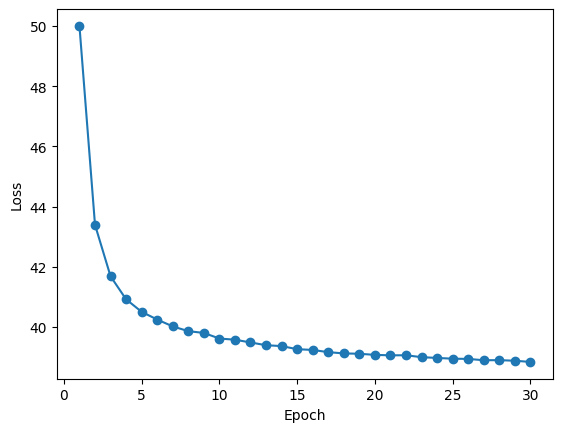

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid 
        
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        # Layer 1
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        # Layer 2
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)
        
        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # Loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction="sum")
        L2 = -torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = -torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size


# Datasets

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(torch.flatten)]  # Flatten the image to vector.
)

dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)

# Plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

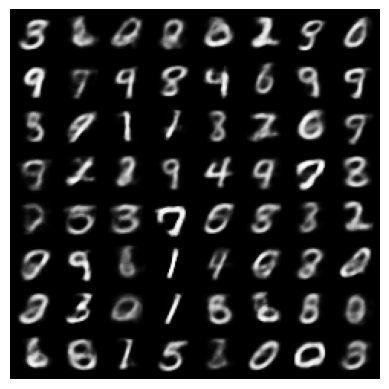

In [9]:
 # visualize generated images
with torch.no_grad():
    sample_size = 64
    z2 = torch.randn(sample_size, latent_dim)
    z1_hat = model.decoder2(z2)
    z1 = reparameterize(z1_hat, torch.ones_like(z1_hat))
    x = model.decoder1(z1)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()